In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

## Join the two datasets

In [23]:
# read trades dataset
traders_df = pd.read_parquet("../data/all_trades_profitability.parquet")
unknown_df = pd.read_parquet("../data/unknown_traders.parquet")


In [25]:
traders_df.staking.value_counts()

staking
non_Olas       56266
non_staking    20954
pearl           6084
quickstart      3975
Name: count, dtype: int64

In [27]:
traders_df["trader_type"] = traders_df["staking"].apply(
    lambda x: "non_Olas" if x == "non_Olas" else "Olas"
)

In [30]:
traders_df.trader_type.value_counts()

trader_type
non_Olas    56266
Olas        31013
Name: count, dtype: int64

In [26]:
unknown_df.staking.value_counts()

staking
non_Olas    1654
Name: count, dtype: int64

In [28]:
unknown_df["trader_type"] = "unclassified"

In [29]:
all_traders = pd.concat([traders_df, unknown_df], ignore_index=True)

In [31]:
all_traders.trader_type.value_counts()

trader_type
non_Olas        56266
Olas            31013
unclassified     1654
Name: count, dtype: int64

In [32]:
# First, create week numbers from timestamps
all_traders["creation_timestamp"] = pd.to_datetime(all_traders["creation_timestamp"])
all_traders = all_traders.sort_values(by="creation_timestamp", ascending=True)
all_traders["month_year_week"] = (
all_traders["creation_timestamp"].dt.to_period("W").dt.strftime("%b-%d-%Y")
)

/var/folders/gp/02mb1d514ng739czlxw1lhh00000gn/T/ipykernel_25153/2488528526.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  all_traders["creation_timestamp"].dt.to_period("W").dt.strftime("%b-%d-%Y")


# WoW Retention

In [33]:
def calculate_wow_retention_by_type(df):
    # Get unique traders per week and type
    weekly_traders = df.groupby(['month_year_week', 'trader_type'])['trader_address'].nunique().reset_index()
    weekly_traders = weekly_traders.sort_values(['trader_type', 'month_year_week'])
    
    # Calculate retention
    retention = []
    # Iterate through each trader type
    for trader_type in weekly_traders['trader_type'].unique():
        type_data = weekly_traders[weekly_traders['trader_type'] == trader_type]
        
        # Calculate retention for each week within this trader type
        for i in range(1, len(type_data)):
            current_week = type_data.iloc[i]['month_year_week']
            previous_week = type_data.iloc[i-1]['month_year_week']
            
            # Get traders in both weeks for this type
            current_traders = set(df[
                (df['month_year_week'] == current_week) & 
                (df['trader_type'] == trader_type)
            ]['trader_address'])
            
            previous_traders = set(df[
                (df['month_year_week'] == previous_week) & 
                (df['trader_type'] == trader_type)
            ]['trader_address'])
            
            retained = len(current_traders.intersection(previous_traders))
            retention_rate = (retained / len(previous_traders)) * 100 if len(previous_traders) > 0 else 0
            
            retention.append({
                'trader_type': trader_type,
                'week': current_week,
                'retained_traders': retained,
                'previous_traders': len(previous_traders),
                'retention_rate': round(retention_rate, 2)
            })
    
    return pd.DataFrame(retention)

In [34]:
wow_retention = calculate_wow_retention_by_type(all_traders)

In [35]:
wow_retention.head()

trader_type         week  retained_traders  previous_traders  retention_rate
0        Olas  Dec-08-2024                93                98           94.90
1        Olas  Dec-15-2024               187               207           90.34
2        Olas  Dec-22-2024               186               213           87.32
3        Olas  Dec-29-2024               143               203           70.44
4        Olas  Jan-05-2025               117               148           79.05

In [39]:
non_olas = wow_retention.loc[wow_retention["trader_type"]=="non_Olas"]
non_olas

trader_type       week  retained_traders  previous_traders  retention_rate
9     non_Olas 2024-12-08               154               154          100.00
10    non_Olas 2024-12-15               301               324           92.90
11    non_Olas 2024-12-22               310               321           96.57
12    non_Olas 2024-12-29               312               341           91.50
13    non_Olas 2025-01-05               304               326           93.25
14    non_Olas 2025-01-12               246               333           73.87
15    non_Olas 2024-11-10                51               251           20.32
16    non_Olas 2024-11-17                90               100           90.00
17    non_Olas 2024-11-24               151               181           83.43

In [47]:
import plotly.express as px
import plotly.graph_objects as go

def plot_wow_retention_by_type(wow_retention):
    wow_retention['week'] = pd.to_datetime(wow_retention['week'])
    wow_retention = wow_retention.sort_values(['trader_type', 'week'])
    fig = px.line(
        wow_retention, 
        x='week', 
        y='retention_rate',
        color='trader_type',
        markers=True,
        title='Weekly Retention Rate by Trader Type',
        labels={
            'week': 'Week',
            'retention_rate': 'Retention Rate (%)',
            'trader_type': 'Trader Type'
        }
    )
    
    fig.update_layout(
        hovermode='x unified',
        legend=dict(
            yanchor="middle",
            y=0.5,
            xanchor="left",
            x=1.02,  # Move legend outside
            orientation="v"
        ),
        yaxis=dict(
            ticksuffix='%',
            range=[0, max(wow_retention['retention_rate']) * 1.1]  # Add 10% padding to y-axis
        ),
        xaxis=dict(
            tickformat='%Y-%m-%d'
        ),
        margin=dict(r=150)  # Add right margin to make space for legend
    )
    
    # Add hover template
    fig.update_traces(
        hovertemplate='<b>%{y:.1f}%</b><br>Week: %{x|%Y-%m-%d}<extra></extra>'
    )
    
    return fig



In [48]:
# Create and show the plot
fig = plot_wow_retention_by_type(wow_retention)
fig.show()

# Cohort retention

In [63]:
def calculate_cohort_retention(df, max_weeks=12):
    # Get first week for each trader
    first_trades = (
        df.groupby("trader_address")
        .agg({"creation_timestamp": "min", "month_year_week": "first"})
        .reset_index()
    )
    first_trades.columns = ["trader_address", "first_trade", "cohort_week"]

    # Get ordered list of unique weeks - converting to datetime for proper sorting
    all_weeks = df["month_year_week"].unique()
    weeks_datetime = pd.to_datetime(all_weeks)
    sorted_weeks_idx = weeks_datetime.argsort()
    all_weeks = all_weeks[sorted_weeks_idx]

    # Create mapping from week string to numeric index
    week_to_number = {week: idx for idx, week in enumerate(all_weeks)}

    # Merge back to get all activities
    cohort_data = pd.merge(
        df, first_trades[["trader_address", "cohort_week"]], on="trader_address"
    )

    # Calculate week number since first activity
    cohort_data["cohort_number"] = cohort_data["cohort_week"].map(week_to_number)
    cohort_data["activity_number"] = cohort_data["month_year_week"].map(week_to_number)
    cohort_data["week_number"] = (
        cohort_data["activity_number"] - cohort_data["cohort_number"]
    )

    # Calculate retention by cohort
    cohort_sizes = cohort_data.groupby("cohort_week")["trader_address"].nunique()
    retention_matrix = cohort_data.groupby(["cohort_week", "week_number"])[
        "trader_address"
    ].nunique()
    retention_matrix = retention_matrix.unstack(fill_value=0)

    # Convert to percentages
    retention_matrix = retention_matrix.div(cohort_sizes, axis=0) * 100

    # Sort index (cohort_week) chronologically
    retention_matrix.index = pd.to_datetime(retention_matrix.index)
    retention_matrix = retention_matrix.sort_index()

    # Limit to max_weeks if specified
    if max_weeks is not None and max_weeks < retention_matrix.shape[1]:
        retention_matrix = retention_matrix.iloc[:, :max_weeks]

    return retention_matrix.round(2)

In [54]:
first_trades = (
    all_traders.groupby("trader_address")
    .agg({"creation_timestamp": "min", "month_year_week": "first"})
    .reset_index()
)
first_trades.columns = ["trader_address", "first_trade", "cohort_week"]

In [56]:
one_trader = all_traders.loc[all_traders["trader_address"]=="0x006f70b4e3c3a3648f31ec16b2e7106fc58166f2"]
one_trader.head()

trader_address market_creator  \
15931  0x006f70b4e3c3a3648f31ec16b2e7106fc58166f2          pearl   
15933  0x006f70b4e3c3a3648f31ec16b2e7106fc58166f2          pearl   
15932  0x006f70b4e3c3a3648f31ec16b2e7106fc58166f2          pearl   

                                                trade_id  \
15931  0x0d72a8dcb46ea982ad9c82c5a6f03cba72a6b71d0x00...   
15933  0xa7392614f48e129f6796f523a47777a5f36dd7030x00...   
15932  0x8984bfbca1805f7355a49c261832043cb39b519e0x00...   

             creation_timestamp  \
15931 2024-11-12 00:36:55+00:00   
15933 2024-11-20 07:37:10+00:00   
15932 2024-11-20 07:41:00+00:00   

                                                   title market_status  \
15931  Will the Chancay mega port in Peru be virtuall...        CLOSED   
15933  Will Google issue a public apology regarding t...        CLOSED   
15932  Will Tesla confirm a location for the installa...        CLOSED   

       collateral_amount outcome_index  trade_fee_amount  \
15931                0.1             1             0.001   
15933                0.1             0             0.001   
15932                0.1             0             0.001   

       outcomes_tokens_traded  ...  earnings  redeemed  redeemed_amount  \
15931                0.224338  ...  0.000000     False              0.0   
15933                0.213349  ...  0.213349     False              0.0   
15932                0.228212  ...  0.000000     False              0.0   

       num_mech_calls  mech_fee_amount  net_earnings       roi  staking  \
15931               2             0.02     -0.121000 -1.000000    pearl   
15933               1             0.01      0.102349  0.922059    pearl   
15932               1             0.01     -0.111000 -1.000000    pearl   

       trader_type  month_year_week  
15931         Olas      Nov-17-2024  
15933         Olas      Nov-24-2024  
15932         Olas      Nov-24-2024  

[3 rows x 23 columns]

In [55]:
first_trades.head()

trader_address               first_trade  \
0  0x006f70b4e3c3a3648f31ec16b2e7106fc58166f2 2024-11-12 00:36:55+00:00   
1  0x00897abcbbefe4f558956b7a9d1b7819677e4d90 2024-11-12 09:10:25+00:00   
2  0x01274796ce41aa8e8312e05a427ffb4b0d2148f6 2024-11-08 00:26:05+00:00   
3  0x01c72d0743a22b70d73c76c5e16ba7524e20e0c0 2024-11-08 19:12:20+00:00   
4  0x0244169d0fe1014b9e71f71070099d9c2364af28 2024-11-16 06:20:25+00:00   

   cohort_week  
0  Nov-17-2024  
1  Nov-17-2024  
2  Nov-10-2024  
3  Nov-10-2024  
4  Nov-17-2024

In [57]:
all_weeks = all_traders["month_year_week"].unique()
weeks_datetime = pd.to_datetime(all_weeks)
sorted_weeks_idx = weeks_datetime.argsort()
all_weeks = all_weeks[sorted_weeks_idx]

In [58]:
all_weeks

array(['Nov-10-2024', 'Nov-17-2024', 'Nov-24-2024', 'Dec-01-2024',
       'Dec-08-2024', 'Dec-15-2024', 'Dec-22-2024', 'Dec-29-2024',
       'Jan-05-2025', 'Jan-12-2025'], dtype=object)

In [59]:
# Create mapping from week string to numeric index
week_to_number = {week: idx for idx, week in enumerate(all_weeks)}

# Merge back to get all activities
cohort_data = pd.merge(
    all_traders, first_trades[["trader_address", "cohort_week"]], on="trader_address"
)

In [60]:
cohort_data["cohort_number"] = cohort_data["cohort_week"].map(week_to_number)
cohort_data["activity_number"] = cohort_data["month_year_week"].map(week_to_number)
cohort_data["week_number"] = (
    cohort_data["activity_number"] - cohort_data["cohort_number"]
)

In [61]:
cohort_data.head()

trader_address market_creator  \
0  0x1c1bb5398ba525c5bca07eeade45958e455de4b3     quickstart   
1  0x2db124224a640765df2842325ab1ab3ec45ebd47     quickstart   
2  0xa156f5e98383c3e2a70faef71cc420780809e130     quickstart   
3  0x211957119a92bd2bb22f835aefae66683428ddd7     quickstart   
4  0xd71b78ce490776a8f0cad6876ea79bc190f7bcce          pearl   

                                            trade_id  \
0  0x50ac9248cf115f69238d9c506f22c223cc9ec20d0x1c...   
1  0xcd00e854ebc743b8a023c9c780d68cb5610fb2160x2d...   
2  0x50ac9248cf115f69238d9c506f22c223cc9ec20d0xa1...   
3  0xcd00e854ebc743b8a023c9c780d68cb5610fb2160x21...   
4  0x868c0dd6983e9b33543471779ff52c814db90fe30xd7...   

         creation_timestamp  \
0 2024-11-08 00:01:05+00:00   
1 2024-11-08 00:01:15+00:00   
2 2024-11-08 00:04:25+00:00   
3 2024-11-08 00:12:05+00:00   
4 2024-11-08 00:15:55+00:00   

                                               title market_status  \
0  Will any new information regarding the selecti...        CLOSED   
1  Will the CDC confirm the source of the E. coli...        CLOSED   
2  Will any new information regarding the selecti...        CLOSED   
3  Will the CDC confirm the source of the E. coli...        CLOSED   
4  Will a peer-reviewed journal publish a follow-...        CLOSED   

   collateral_amount outcome_index  trade_fee_amount  outcomes_tokens_traded  \
0           0.772726             0          0.007727                2.087857   
1           1.534418             0          0.015344                3.814142   
2           0.415013             1          0.004150                0.672596   
3           0.600311             1          0.006003                1.069992   
4           0.025000             1          0.000250                0.050876   

   ...  mech_fee_amount  net_earnings       roi      staking  trader_type  \
0  ...             0.06     -0.840453 -1.000000  non_staking         Olas   
1  ...             0.02      2.244380  1.429758  non_staking         Olas   
2  ...             0.02      0.233433  0.531542  non_staking         Olas   
3  ...             0.02     -0.626314 -1.000000  non_staking         Olas   
4  ...             0.01      0.015626  0.443287        pearl         Olas   

   month_year_week  cohort_week  cohort_number  activity_number  week_number  
0      Nov-10-2024  Nov-10-2024              0                0            0  
1      Nov-10-2024  Nov-10-2024              0                0            0  
2      Nov-10-2024  Nov-10-2024              0                0            0  
3      Nov-10-2024  Nov-10-2024              0                0            0  
4      Nov-10-2024  Nov-10-2024              0                0            0  

[5 rows x 27 columns]

In [62]:
cohort_data.tail()

trader_address market_creator  \
88928  0xa8efa5bb5c6ad476c9e0377dbf66cc41cb6d5bdd     quickstart   
88929  0x3e013a3ca156032005c239de6d84badd3f9b13a9     quickstart   
88930  0xd4fc4305dc1226c38356024c26cde985817f137f     quickstart   
88931  0xc918c15b87746e6351e5f0646ddcaaca11af8568     quickstart   
88932  0xf758c18402ddef2d231911c4c326aa46510788f0     quickstart   

                                                trade_id  \
88928  0xfc75b4d9aadde4ca459b64fb51088ef38bf442830xa8...   
88929  0x0b2f7c5f872b9f0323422f3b5c3b44676baf26ca0x3e...   
88930  0x0b2f7c5f872b9f0323422f3b5c3b44676baf26ca0xd4...   
88931  0x0b2f7c5f872b9f0323422f3b5c3b44676baf26ca0xc9...   
88932  0x0b2f7c5f872b9f0323422f3b5c3b44676baf26ca0xf7...   

             creation_timestamp  \
88928 2025-01-07 10:54:40+00:00   
88929 2025-01-07 12:17:25+00:00   
88930 2025-01-07 13:55:00+00:00   
88931 2025-01-07 15:14:50+00:00   
88932 2025-01-07 22:00:55+00:00   

                                                   title market_status  \
88928  Will a recall of Tesla Cybertruck vehicles be ...        CLOSED   
88929  Will Gazprom announce a new pipeline project a...        CLOSED   
88930  Will Gazprom announce a new pipeline project a...        CLOSED   
88931  Will Gazprom announce a new pipeline project a...        CLOSED   
88932  Will Gazprom announce a new pipeline project a...        CLOSED   

       collateral_amount outcome_index  trade_fee_amount  \
88928       1.969849e+00             0      1.969849e-02   
88929       5.098594e-03             0      5.098594e-05   
88930       2.000000e+00             0      2.000000e-02   
88931       5.566732e-07             1      5.566732e-09   
88932       1.000000e-05             1      1.000000e-07   

       outcomes_tokens_traded  ...  mech_fee_amount  net_earnings       roi  \
88928                4.510793  ...              0.0  2.521246e+00  1.267246   
88929                0.007520  ...              0.0  2.370460e-03  0.460321   
88930                1.980169  ...              0.0 -3.983078e-02 -0.019718   
88931                1.081069  ...              0.0 -5.622399e-07 -1.000000   
88932                0.820458  ...              0.0 -1.010000e-05 -1.000000   

        staking   trader_type  month_year_week  cohort_week  cohort_number  \
88928  non_Olas  unclassified      Jan-12-2025  Dec-08-2024              4   
88929  non_Olas  unclassified      Jan-12-2025  Dec-08-2024              4   
88930  non_Olas  unclassified      Jan-12-2025  Dec-22-2024              6   
88931  non_Olas  unclassified      Jan-12-2025  Dec-08-2024              4   
88932  non_Olas  unclassified      Jan-12-2025  Dec-08-2024              4   

       activity_number  week_number  
88928                9            5  
88929                9            5  
88930                9            3  
88931                9            5  
88932                9            5  

[5 rows x 27 columns]

In [64]:
cohort_retention = calculate_cohort_retention(all_traders)

In [65]:
cohort_retention.head()

week_number      0       1      2      3      4      5      6      7      8  \
cohort_week                                                                   
2024-11-10   100.0   91.83  81.71  56.42  86.77  82.88  80.54  70.04  64.59   
2024-11-17   100.0   75.00  45.00  66.88  67.50  67.50  51.25  48.12  33.75   
2024-11-24   100.0   51.72  75.86  72.41  75.86  65.52  62.07  51.72   0.00   
2024-12-01   100.0  100.00  90.48  80.95  66.67  71.43  52.38   0.00   0.00   
2024-12-08   100.0   88.82  86.47  85.88  78.24  70.59   0.00   0.00   0.00   

week_number      9  
cohort_week         
2024-11-10   41.25  
2024-11-17    0.00  
2024-11-24    0.00  
2024-12-01    0.00  
2024-12-08    0.00

In [52]:
cohort_retention.head()

week_number      0       1      2      3      4      5      6    7    8    9
cohort_week                                                                 
Dec-01-2024  100.0  100.00  90.48  80.95  66.67  71.43  52.38  0.0  0.0  0.0
Dec-08-2024  100.0   88.82  86.47  85.88  78.24  70.59   0.00  0.0  0.0  0.0
Dec-15-2024  100.0   68.75  37.50  25.00   9.38   0.00   0.00  0.0  0.0  0.0
Dec-22-2024  100.0   59.38  50.00  25.00   0.00   0.00   0.00  0.0  0.0  0.0
Dec-29-2024  100.0   69.23   0.00   0.00   0.00   0.00   0.00  0.0  0.0  0.0

In [53]:
cohort_retention.tail()

week_number      0      1      2      3      4      5      6      7      8  \
cohort_week                                                                  
Jan-05-2025  100.0  42.86   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
Jan-12-2025  100.0   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
Nov-10-2024  100.0  91.83  81.71  56.42  86.77  82.88  80.54  70.04  64.59   
Nov-17-2024  100.0  75.00  45.00  66.88  67.50  67.50  51.25  48.12  33.75   
Nov-24-2024  100.0  51.72  75.86  72.41  75.86  65.52  62.07  51.72   0.00   

week_number      9  
cohort_week         
Jan-05-2025   0.00  
Jan-12-2025   0.00  
Nov-10-2024  41.25  
Nov-17-2024   0.00  
Nov-24-2024   0.00

# Visualization of the cohort matrix

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_cohort_retention_heatmap(retention_matrix):
    # Create a copy of the matrix to avoid modifying the original
    retention_matrix = retention_matrix.copy()
    
    # Convert index to datetime and format to date string
    retention_matrix.index = pd.to_datetime(retention_matrix.index).strftime('%Y-%m-%d')
    
    # Create figure and axes with specified size
    plt.figure(figsize=(12, 8))
    
    # Create mask for NaN values
    mask = retention_matrix.isna()
    
    # Create heatmap
    ax = sns.heatmap(
        data=retention_matrix,
        annot=True,  # Show numbers in cells
        fmt='.1f',   # Format numbers to 1 decimal place
        cmap='YlOrRd',  # Yellow to Orange to Red color scheme
        vmin=0,
        vmax=100,
        center=50,
        cbar_kws={'label': 'Retention Rate (%)', 'format': PercentFormatter()},
        mask=mask,
        annot_kws={'size': 8}
    )
    
    # Customize the plot
    plt.title('Cohort Retention Analysis', pad=20, size=14)
    plt.xlabel('Weeks Since First Trade', size=12)
    plt.ylabel('Cohort Starting Week', size=12)
    
    # Format week numbers on x-axis
    x_labels = [f'Week {i}' for i in retention_matrix.columns]
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    
    # Set y-axis labels rotation
    plt.yticks(rotation=0)
    
    # Add gridlines
    ax.set_axisbelow(True)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt




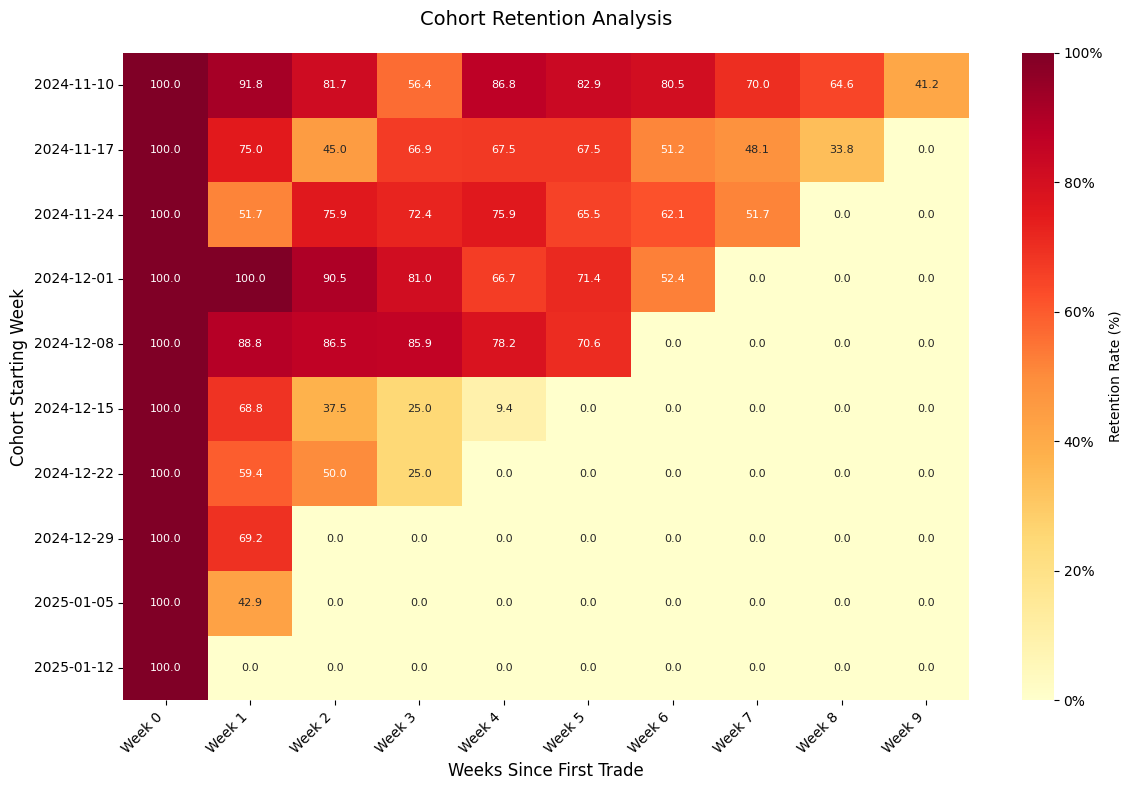

In [71]:
fig = plot_cohort_retention_heatmap(cohort_retention)